## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from IPython.display import clear_output
from statistics import mean

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 206kB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.40MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.05MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [7]:
for test_img, test_label in test_loader:
    print(test_img.shape)
    print(test_label.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])


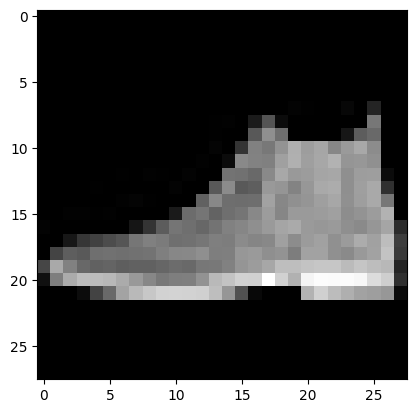

In [8]:
plt.imshow(test_img.cpu().detach().numpy()[0][0], cmap='gray')

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
         LeakyReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
       LogSoftmax-11                   [-1, 10]               0
Total params: 552,106
Trainable params: 552,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Your experiments come here:

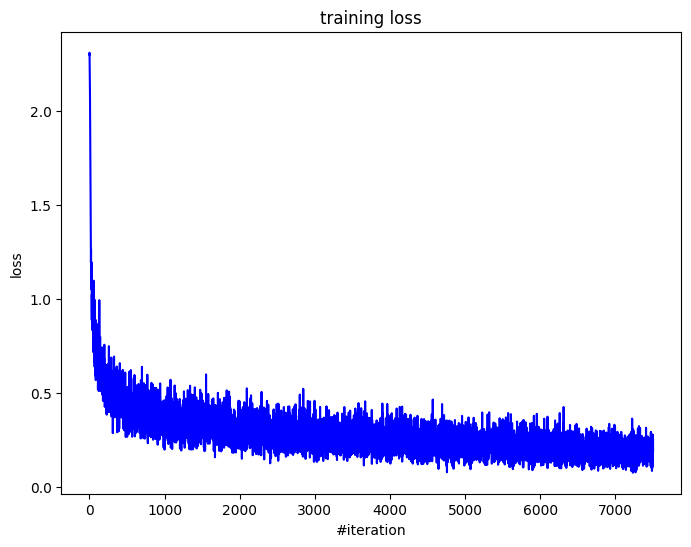

current loss: 0.188414


In [12]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epoch = 16
loss_history = []

for epoch in range(n_epoch):
    for x_train, y_train in train_loader:
        opt.zero_grad()
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        pred = model.forward(x_train)
        loss_value = loss_func(pred, y_train)
        loss_history.append(loss_value.item())  # Fix applied here
        loss_value.backward()
        opt.step()

    clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title('training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history, 'b')
    plt.show()

    print('current loss: %f' % loss_value.item())


In [14]:
def compute_accuracy_from_tensors(y_true_tensor, y_pred_tensor):
    y_true_numpy = y_true_tensor.cpu().detach().numpy()[:, None]
    encoder = OneHotEncoder()
    encoder.fit(np.arange(10)[:, None])
    y_pred_decoded = encoder.inverse_transform(y_pred_tensor.cpu().detach().numpy())
    return accuracy_score(y_true_numpy, y_pred_decoded)

In [15]:
def compute_average_accuracy(model):
    accuracy_list = []
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_pred = model.forward(x_test)
        accuracy_list.append(compute_accuracy_from_tensors(y_test, test_pred))

    print('accuracy score on all test data is: ', mean(accuracy_list))

In [16]:
compute_average_accuracy(model)

accuracy score on all test data is:  0.89443359375


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [17]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [18]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
         LeakyReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
       LogSoftmax-11                   [-1, 10]               0
Total params: 552,106
Trainable params: 552,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [19]:
len(fmnist_dataset_train)

60000

In [20]:
fmnist_dataset_train_cut, _ = torch.utils.data.random_split(fmnist_dataset_train, [5000, 55000])

In [21]:
len(fmnist_dataset_test)

10000

In [22]:
train_loader_cutted = torch.utils.data.DataLoader(fmnist_dataset_train_cut,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [23]:
for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    break
x_test.shape

torch.Size([256, 1, 28, 28])

In [24]:
def plot_history(train_history, test_history, name):
    plt.figure(figsize=(8, 6))
    plt.title(name)
    plt.xlabel('#iteration')
    plt.ylabel(name)
    plt.plot(train_history, 'b', label='train')
    plt.plot(test_history, 'g', label='test')
    plt.legend()
    plt.show()

In [27]:
def run_experiment(model, n_epoch):
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = torch.nn.CrossEntropyLoss()

    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(n_epoch):
        for x_train, y_train in train_loader_cutted:
            opt.zero_grad()
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            # Train step
            train_pred = model.forward(x_train)
            train_loss_value = loss_func(train_pred, y_train)
            train_loss_history.append(train_loss_value.cpu().item())  # Move to CPU before appending
            train_accuracy_history.append(compute_accuracy_from_tensors(y_train, train_pred))
            train_loss_value.backward()
            opt.step()

            # Test step
            test_pred = model.forward(x_test)
            test_loss_value = loss_func(test_pred, y_test)
            test_loss_history.append(test_loss_value.cpu().item())  # Move to CPU before appending
            test_accuracy_history.append(compute_accuracy_from_tensors(y_test, test_pred))

        clear_output(wait=True)
        plot_history(train_loss_history, test_loss_history, 'loss')
        plot_history(train_accuracy_history, test_accuracy_history, 'accuracy')

        print('current train loss: %f' % train_loss_value.cpu().item())
        print('current test loss: %f' % test_loss_value.cpu().item())
        print('current train accuracy score: ', train_accuracy_history[-1])
        print('current test accuracy score: ', test_accuracy_history[-1])

    compute_average_accuracy(model=model)

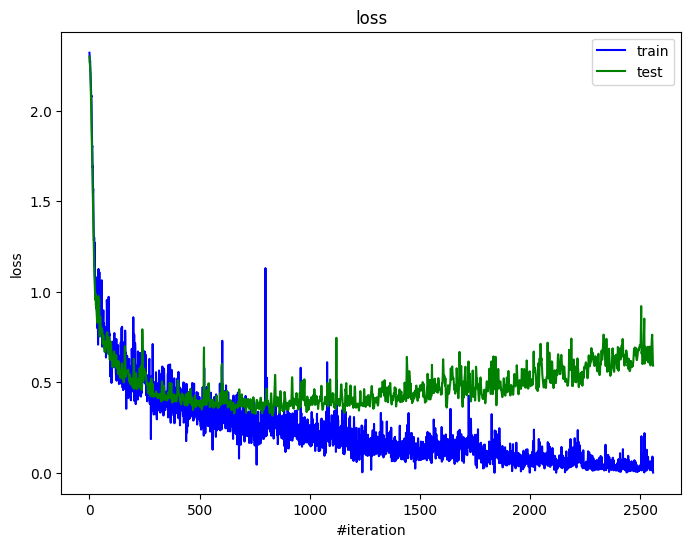

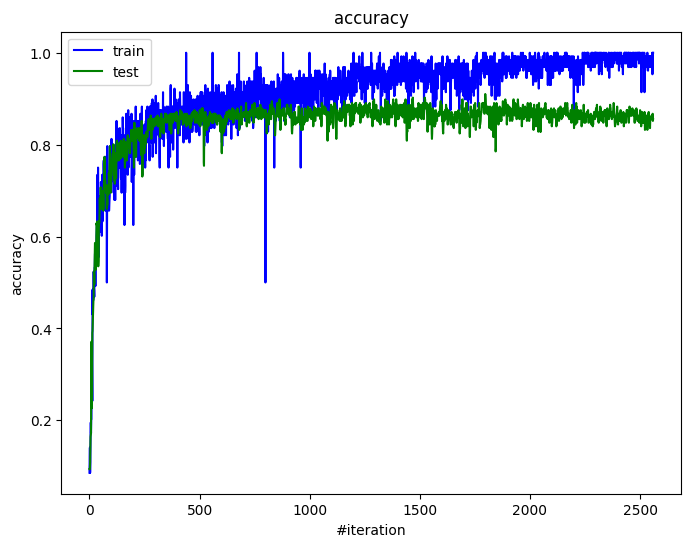

current train loss: 0.000905
current test loss: 0.591906
current train accuracy score:  1.0
current test accuracy score:  0.85546875
accuracy score on all test data is:  0.8412109375


In [28]:
model = OverfittingNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [29]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [30]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
         LeakyReLU-4                  [-1, 512]               0
       BatchNorm1d-5                  [-1, 512]           1,024
            Linear-6                  [-1, 256]         131,328
         LeakyReLU-7                  [-1, 256]               0
       BatchNorm1d-8                  [-1, 256]             512
            Linear-9                   [-1, 64]          16,448
          Dropout-10                   [-1, 64]               0
        LeakyReLU-11                   [-1, 64]               0
      BatchNorm1d-12                   [-1, 64]             128
           Linear-13                   [-1, 32]           2,080
        LeakyReLU-14                   

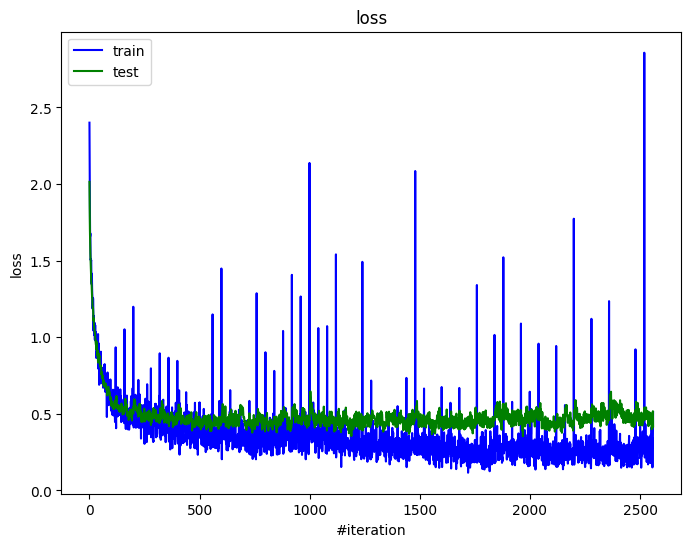

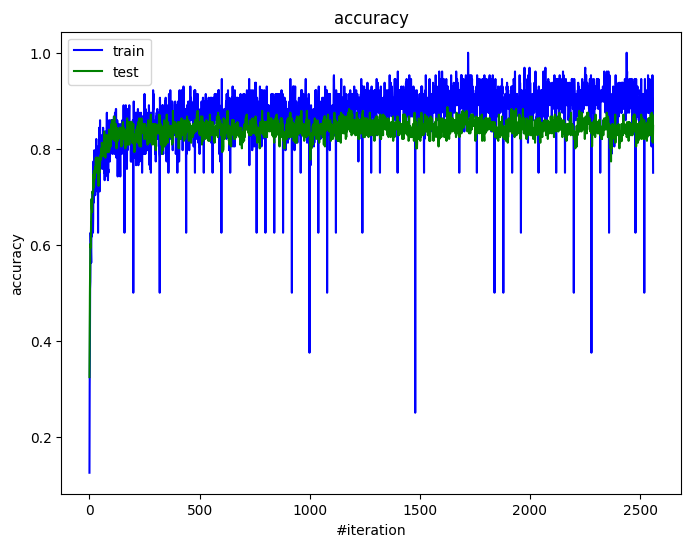

current train loss: 0.511674
current test loss: 0.417696
current train accuracy score:  0.75
current test accuracy score:  0.84765625
accuracy score on all test data is:  0.82236328125


In [31]:
model = FixedNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

In [32]:
# try without dropout
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [33]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
       BatchNorm1d-4                  [-1, 512]           1,024
            Linear-5                  [-1, 256]         131,328
         LeakyReLU-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
            Linear-8                   [-1, 64]          16,448
         LeakyReLU-9                   [-1, 64]               0
      BatchNorm1d-10                   [-1, 64]             128
           Linear-11                   [-1, 32]           2,080
        LeakyReLU-12                   [-1, 32]               0
      BatchNorm1d-13                   [-1, 32]              64
           Linear-14                   

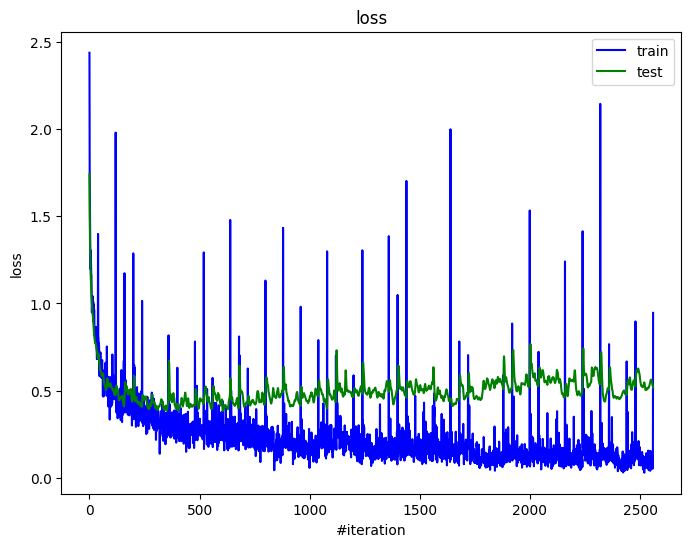

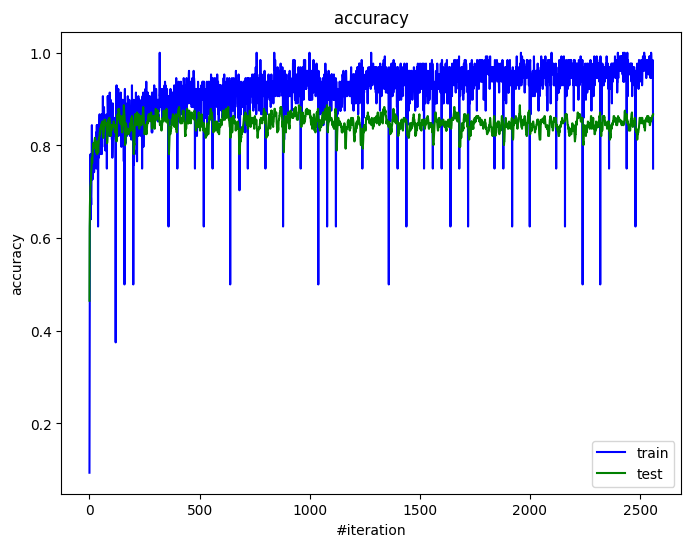

current train loss: 0.945696
current test loss: 0.516308
current train accuracy score:  0.75
current test accuracy score:  0.8671875
accuracy score on all test data is:  0.8318359375


In [34]:
model = FixedNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

In [35]:
# try without batchnorm
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [36]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
         LeakyReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                   [-1, 64]          16,448
           Dropout-8                   [-1, 64]               0
         LeakyReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
        LeakyReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
       LogSoftmax-13                   [-1, 10]               0
Total params: 552,106
Trainable params:

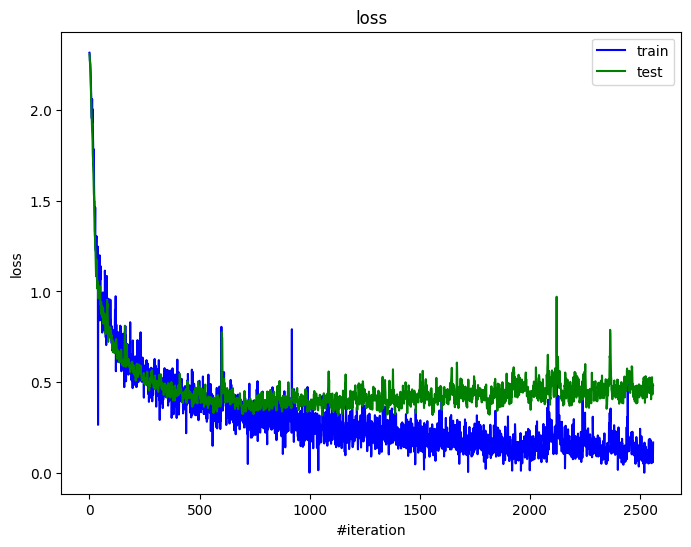

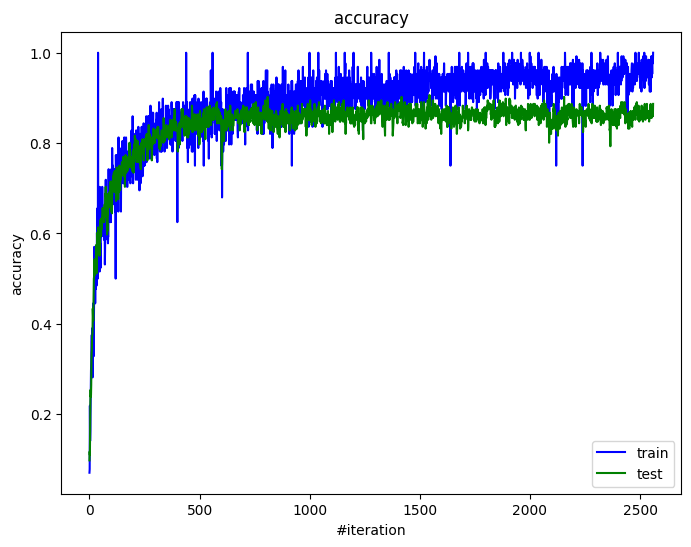

current train loss: 0.167005
current test loss: 0.483229
current train accuracy score:  1.0
current test accuracy score:  0.88671875
accuracy score on all test data is:  0.8419921875


In [37]:
model = FixedNeuralNetwork().to(device)
run_experiment(model=model, n_epoch=64)

### Conclusions:
**Batchnorm и Dropout** — действительно эффективные методы борьбы с переоснащением. Наиболее значительный эффект будет достигнут, если мы применим Dropout и Batchnorm вместе. Хотя на самом деле они не дали оценки точности для всех тестовых данных, очевидно, что они уменьшают переобучение, как видно на графиках.

BatchNorm нормализует активации внутри нейронной сети, что помогает избежать проблемы исчезающих или взрывающихся градиентов, ускоряет обучение и делает модель более стабильной. Это достигается за счет нормализации входов в каждый слой на основе статистики (среднего значения и дисперсии), вычисленных на мини-батче. Такой подход стабилизирует обучение, позволяя использовать более высокие скорости обучения и ускоряя сходимость модели.

Dropout — это техника регуляризации, которая случайным образом "выключает" (зануляет) нейроны в процессе обучения, что помогает избежать чрезмерной зависимости модели от отдельных нейронов. Это способствует улучшению обобщающей способности сети, так как она не может полагаться на определённые признаки, и таким образом предотвращается переобучение.

**Когда мы применяем BatchNorm и Dropout вместе, мы получаем два разных аспекта регуляризации:**

- BatchNorm помогает стабилизировать обучение и ускоряет его, предотвращая проблемы с градиентами.
- Dropout работает как метод регуляризации, который препятствует переобучению, уменьшая зависимость модели от отдельных нейронов.

При этом, хотя они уменьшают переобучение, важно понимать, что их влияние зависит от множества факторов, таких как архитектура сети, количество данных и т. д. Иногда использование обоих методов действительно может значительно снизить переобучение, а иногда оптимальным будет выбор одного из этих методов в зависимости от конкретной задачи и данных.